<a href="https://colab.research.google.com/github/taniasahu/Automatic-Modulation-Classification-/blob/main/ResNet_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy -q
!pip install tensorflow -q
!pip install scipy -q
!pip install matplotlib -q
!pip install keras -q
!pip install scikit-learn -q

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to file location in Google Drive
file_path = '/content/drive/My Drive/AMC_dataset.mat'

Mounted at /content/drive


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
from scipy.io import loadmat

# Load dataset
data = loadmat(file_path)
X = data['data']  # Shape: (55000, 1024, 2)
y = data['labels'].flatten() - 1  # 0-based indexing
split = data['split'].flatten()  # 0=train, 1=val, 2=test

# Split dataset
X_train = X[split == 0]
y_train = y[split == 0]
X_val = X[split == 1]
y_val = y[split == 1]
X_test = X[split == 2]
y_test = y[split == 2]

# Define residual block
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, 1, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, 3, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    if stride > 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Build CNN model
def build_cnn_model(input_shape=(1024, 2), num_classes=11):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(128, 7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(3, strides=2, padding='same')(x)

    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.03))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Create and compile model
model = build_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Model summary
model.summary()

# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Save model
model.save('ResNet_CNN.keras')

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1024, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_191 (Conv1D) │ (None, 512, 128)  │      1,920 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 128)  │        512 │ conv1d_191[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_182 (ReLU)    │ (None, 512, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 256, 128)  │          0 │ re_lu_182[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_192 (Conv1D) │ (None, 256, 128)  │     16,512 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512 │ conv1d_192[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_183 (ReLU)    │ (None, 256, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_193 (Conv1D) │ (None, 256, 128)  │     49,280 │ re_lu_183[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512 │ conv1d_193[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_84 (Add)        │ (None, 256, 128)  │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_184 (ReLU)    │ (None, 256, 128)  │          0 │ add_84[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_194 (Conv1D) │ (None, 256, 128)  │     16,512 │ re_lu_184[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512 │ conv1d_194[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_185 (ReLU)    │ (None, 256, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_195 (Conv1D) │ (None, 256, 128)  │     49,280 │ re_lu_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 128)  │        512 │ conv1d_195[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_85 (Add)        │ (None, 256, 128)  │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_184[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_186 (ReLU)    │ (None, 256, 128)  │          0 │ add_85[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_196 (Conv1D) │ (None, 256, 128)  │     16,512 │ re_lu_186[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,682,315 (21.68 MB)

 Trainable params: 5,665,675 (21.61 MB)

 Non-trainable params: 16,640 (65.00 KB)

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 129s 536ms/step - accuracy: 0.5631 - loss: 10.4822 - val_accuracy: 0.1293 - val_loss: 20.5953 - learning_rate: 1.0000e-04
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 85s 333ms/step - accuracy: 0.8437 - loss: 6.2051 - val_accuracy: 0.7089 - val_loss: 4.7008 - learning_rate: 1.0000e-04
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 81s 330ms/step - accuracy: 0.8771 - loss: 3.7890 - val_accuracy: 0.8241 - val_loss: 2.8441 - learning_rate: 1.0000e-04
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.9076 - loss: 2.3611 - val_accuracy: 0.7226 - val_loss: 2.2016 - learning_rate: 1.0000e-04
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 49s 319ms/step - accuracy: 0.9479 - loss: 1.4800 - val_accuracy: 0.8236 - val_loss: 1.3863 - learning_rate: 1.0000e-04
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 84s 333ms/step - accuracy: 0.9687 - loss: 0.9560 - val_accuracy: 0.7565 - val_loss: 1.3353 - learning_rate: 1.0000e-04
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━

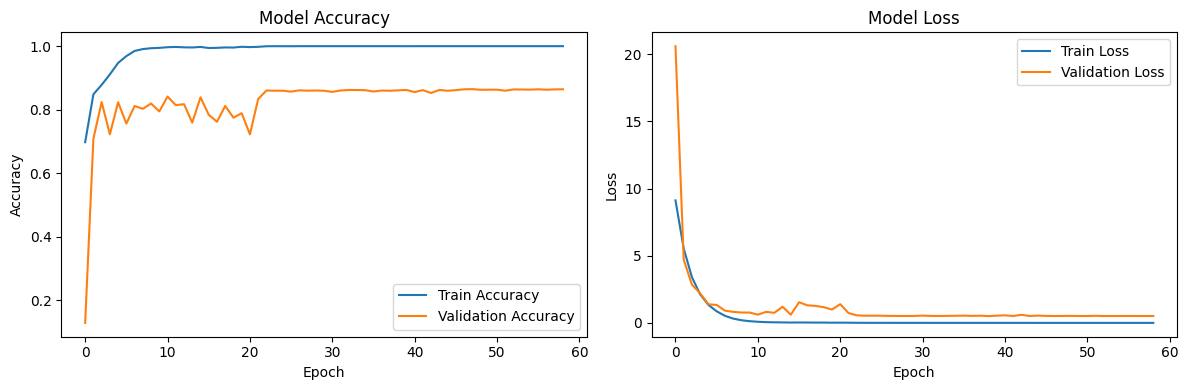

In [18]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load dataset
sio.loadmat(file_path)
X = data['data']
y = data['labels'].flatten() - 1  # Convert to 0-based indexing
split = data['split'].flatten()

# Get test set
X_test = X[split == 2]
y_test = y[split == 2]

# Load your trained model
model = load_model('ResNet_CNN.keras')

# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = [ 'BPSK', 'QPSK', '8PSK', '16QAM', '64QAM','PAM4', 'GFSK', 'CPFSK', 'B-FM', 'DSB-AM', 'SSB-AM']

Test Accuracy: 86.56%
Test Loss: 0.5069
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


In [14]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

        BPSK       1.00      0.96      0.98       773
        QPSK       0.79      0.69      0.74       761
        8PSK       0.69      0.77      0.73       751
       16QAM       0.84      0.73      0.78       724
       64QAM       0.82      0.96      0.89       794
        PAM4       0.99      1.00      1.00       737
        GFSK       1.00      0.99      1.00       741
       CPFSK       1.00      1.00      1.00       733
        B-FM       1.00      1.00      1.00       747
      DSB-AM       1.00      1.00      1.00       344
      SSB-AM       1.00      1.00      1.00       553

    accuracy                           0.91      7658
   macro avg       0.92      0.92      0.92      7658
weighted avg       0.91      0.91      0.91      7658



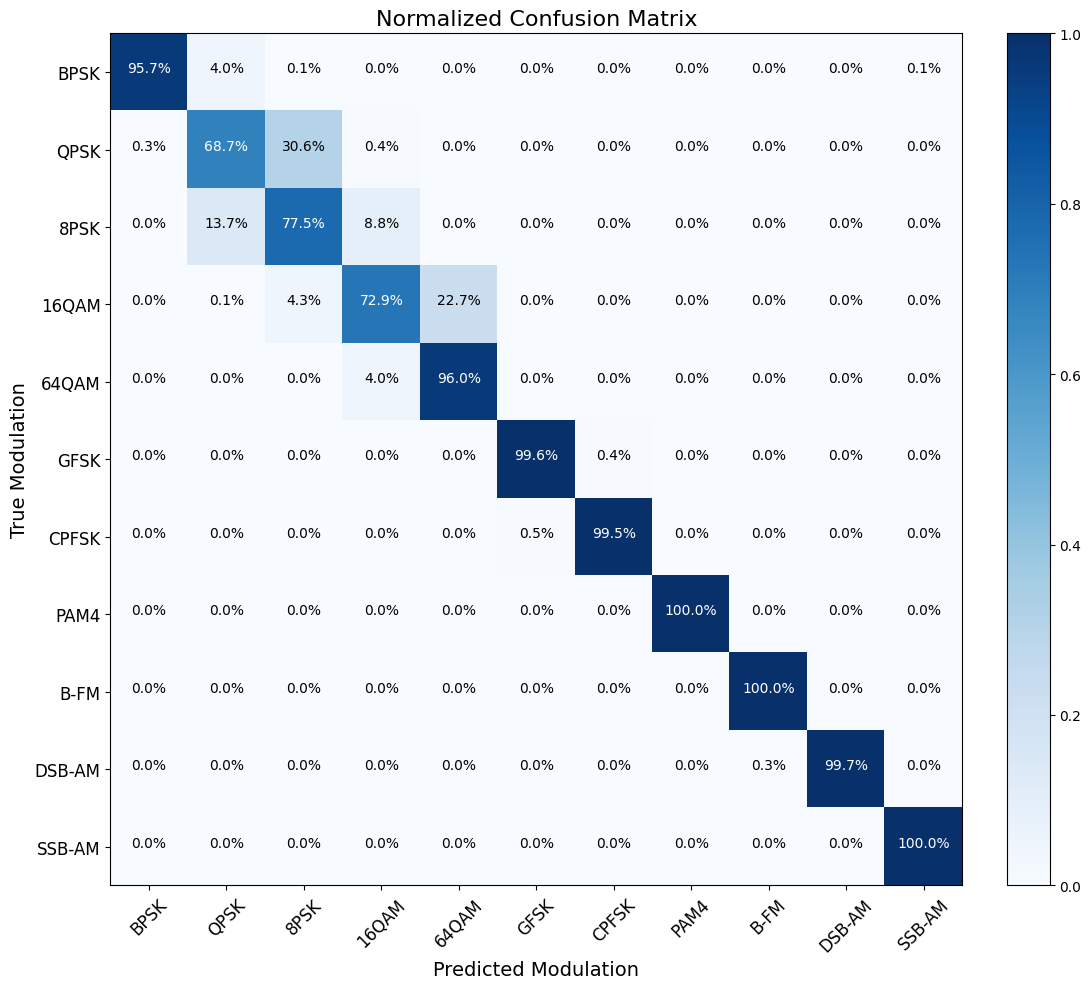

In [22]:
# Class names
class_names = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM",
               "GFSK", "CPFSK", "PAM4", "B-FM", "DSB-AM", "SSB-AM"]

# Plot confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.colorbar(fraction=0.046, pad=0.04)

# Add labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, fontsize=12)
plt.yticks(tick_marks, class_names, fontsize=12)

# Add text annotations
thresh = cm_norm.max() / 1.5
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]*100:.1f}%",
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black",
                 fontsize=10)

plt.ylabel('True Modulation', fontsize=14)
plt.xlabel('Predicted Modulation', fontsize=14)
plt.tight_layout()

# Save and show
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
